# Impact of Fiber Collisions on P(k) wedges

This is an IPython notebook to explore the impact of fiber collisions on P(k) wedges!

In [2]:
import numpy as np
from scipy.special import legendre
from scipy.integrate import quad as quad_int

import matplotlib.pyplot as plt
%matplotlib inline
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors

In [3]:
prettyplot()
pretty_colors = prettycolors()

## Estimating $P(k)$ wedges from multipoles $P_\ell(k)$

$$P_{\mu_1}^{\mu_2} = \sum\limits_{\ell} T_{n,\ell} P_\ell(k)$$

where 

$$T_{n, \ell} = \frac{1}{\mu_2 - \mu_1} \int\limits_{\mu_1}^{\mu_2} \mathcal{L}_\ell(\mu) {\rm d}\mu$$

In [4]:
# calculate Tnl first for n = 2
def Tnl(en, EN, ell): 
    ''' Calculate the coefficient used for estiamte powerspectrum wedges from multipoles
    
    parameters
    ----------
    en : (int)
        en-th wedge out of EN equally spaced wedges for mu in [0, 1]
    EN : (int)
        Specifies the number of equally spaced wedges
    ell : multipole
    '''
    # calculate mu1 and mu2 first
    mu_wid = 1./np.float(EN)   
    mu1 = mu_wid*np.float(en - 1)
    mu2 = mu1 + mu_wid
    
    tmp_Leg = legendre(ell) # set up legendre polynomial
    return 1./(mu2 - mu1) * quad_int(tmp_Leg, mu1, mu2)[0]

### $T_{n, \ell}$

In [5]:
for nn in [1,2]: 
    for ll in [0,2,4,6,8,10]: 
        print 'n=', nn, 'l=', ll, Tnl(nn, 2, ll)

n= 1 l= 0 1.0
n= 1 l= 2 -0.375
n= 1 l= 4 0.1171875
n= 1 l= 6 0.0205078125
n= 1 l= 8 -0.0577697753906
n= 1 l= 10 0.0315971374512
n= 2 l= 0 1.0
n= 2 l= 2 0.375
n= 2 l= 4 -0.1171875
n= 2 l= 6 -0.0205078125
n= 2 l= 8 0.0577697753906
n= 2 l= 10 -0.0315971374512


In [7]:
print Tnl(1, 3, 2), Tnl(2, 3, 2), Tnl(3, 3, 2)

-0.444444444444 -0.111111111111 0.555555555556


In [9]:
# read in the powerspectra (Nseries)
def Read_Pk_true(i_mock):
    ''' Read in the *true* Nseries power spectra
    
    parameters
    ----------
    i_mock : (int)
        mock catalog number
    '''
    dat_dir = '/Volumes/750GB/hahn/fibcol/Nseries/'
    dat_file = ''.join([dat_dir, 'POWER_Q_CutskyN', str(i_mock), '.fidcosmo.dat.grid960.P020000.box3600'])
    
    k, p0k, p2k, p4k = np.loadtxt(dat_file, unpack=True, usecols=[0, 1, 2, 3])
    
    out_dict = {}
    out_dict['k'] = k 
    out_dict['p0k'] = p0k
    out_dict['p2k'] = p2k
    out_dict['p4k'] = p4k
    
    return out_dict

def Read_Pk_NN(i_mock):
    ''' Read in the *NN-upweighted* Nseries power spectra
    
    parameters
    ----------
    i_mock : (int)
        mock catalog number
    '''
    dat_dir = '/Volumes/750GB/hahn/fibcol/Nseries/'
    dat_file = ''.join([dat_dir, 'POWER_Q_CutskyN', str(i_mock), '.fidcosmo.fibcoll.dat.grid960.P020000.box3600'])
    
    k, p0k, p2k, p4k = np.loadtxt(dat_file, unpack=True, usecols=[0, 1, 2, 3])
    
    out_dict = {}
    out_dict['k'] = k 
    out_dict['p0k'] = p0k
    out_dict['p2k'] = p2k
    out_dict['p4k'] = p4k
    
    return out_dict

In [10]:
def Pk_wedge(pk_dict, en, EN): 
    '''Calculate P(k) wedge given P(k) multipole dictionary. 
    
    parameters
    ----------
    pk_dict : (dict)
        dictionary with keys (k, p0k, p2k, p4k)
    '''
    for ell in [0, 2, 4]:
        coeff = Tnl(en, EN, ell)
        if ell == 0: 
            wedge = coeff * pk_dict['p'+str(ell)+'k']
        else: 
            wedge += coeff * pk_dict['p'+str(ell)+'k']
    return [pk_dict['k'], wedge]

# Comparison between true and NN-upweighted fiber collided P(k)

In [11]:
# average Nseries values

avg_Pk_wedge_true = {}
avg_Pk_wedge_NN = {} 
for en in [1,2,3]:
    for i_mock in range(1, 85): 
        Pwed_i = Pk_wedge(Read_Pk_true(i_mock), en, 3)
        Pwed_NN_i = Pk_wedge(Read_Pk_NN(i_mock), en, 3)
        if i_mock == 1: 
            avg_Pk_wed_true = Pwed_i
            avg_Pk_wed_NN = Pwed_NN_i
        else: 
            avg_Pk_wed_true[1] += Pwed_i[1]
            avg_Pk_wed_NN[1] += Pwed_NN_i[1]
    avg_Pk_wedge_true[str(en)+',3'] = avg_Pk_wed_true[1]/84.
    avg_Pk_wedge_NN[str(en)+',3'] = avg_Pk_wed_NN[1]/84.
avg_Pk_wedge_true['k'] = avg_Pk_wed_true[0]
avg_Pk_wedge_NN['k'] = avg_Pk_wed_NN[0]

In [12]:
# calculate the standard deviation

sigma_Pk_wedge_true = {} 
sigma_Pk_wedge_NN = {}
for en in [1,2,3]:
    for i_mock in range(1, 85): 
        Pwed_i = Pk_wedge(Read_Pk_true(i_mock), en, 3)
        Pwed_NN_i = Pk_wedge(Read_Pk_NN(i_mock), en, 3)
        
        if i_mock == 1: 
            var_Pk_wedge_true = (Pwed_i[1] - avg_Pk_wedge_true[str(en)+',3'])**2
            var_Pk_wedge_NN = (Pwed_i[1] - avg_Pk_wedge_NN[str(en)+',3'])**2
        else: 
            var_Pk_wedge_true += (Pwed_i[1] - avg_Pk_wedge_true[str(en)+',3'])**2
            var_Pk_wedge_NN += (Pwed_i[1] - avg_Pk_wedge_NN[str(en)+',3'])**2
    var_Pk_wedge_true /= 83.
    var_Pk_wedge_NN /= 83.
    
    sigma_Pk_wedge_true[str(en)+',3'] = np.sqrt(var_Pk_wedge_true)
    sigma_Pk_wedge_NN[str(en)+',3'] = np.sqrt(var_Pk_wedge_NN)
sigma_Pk_wedge_true['k'] = avg_Pk_wedge_true['k']
sigma_Pk_wedge_NN['k'] = avg_Pk_wedge_NN['k']

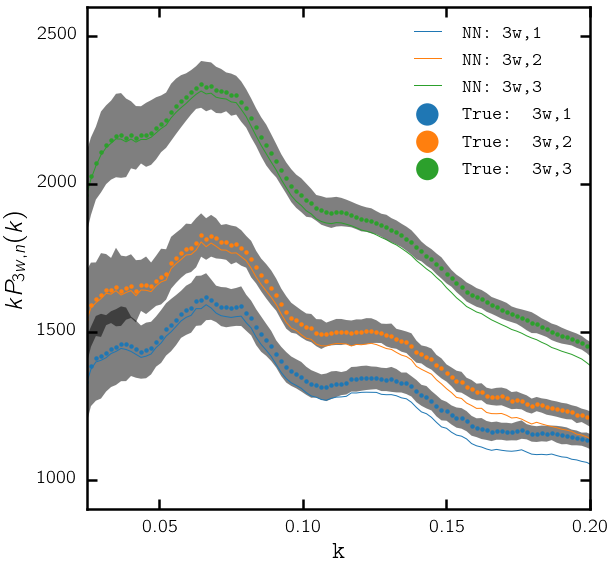

In [13]:
fig = plt.figure(figsize=(9,9))
sub = fig.add_subplot(111)

for i_en, en in enumerate([1,2,3]): 
    Pwed = [avg_Pk_wedge_true['k'], avg_Pk_wedge_true[str(en)+',3']]
    Pwed_NN = [avg_Pk_wedge_NN['k'], avg_Pk_wedge_NN[str(en)+',3']]
    
    sub.fill_between(Pwed[0], Pwed[0]*(Pwed[1]-sigma_Pk_wedge_true[str(en)+',3']), 
                     Pwed[0]*(Pwed[1]+sigma_Pk_wedge_true[str(en)+',3']), color='k', lw=0, alpha=0.5)
    
    sub.scatter(Pwed[0], Pwed[0]*Pwed[1], c=pretty_colors[2*i_en+1], lw=0, label='True: 3w,'+str(en))
    sub.plot(Pwed_NN[0], Pwed_NN[0]*Pwed_NN[1], c=pretty_colors[2*i_en+1], label='NN: 3w,'+str(en))

sub.set_xlabel('k', fontsize=25)
sub.set_ylabel(r'$k P_{3w, n}(k)$', fontsize=25)
sub.set_xlim([0.025, 0.2])
sub.set_ylim([900, 2600])
sub.set_xticks([0.05, 0.10, 0.15, 0.2])
sub.set_yticks([1000, 1500, 2000, 2500])
sub.legend(loc='upper right', scatterpoints=1)

# $P(k)$ wedge residuals

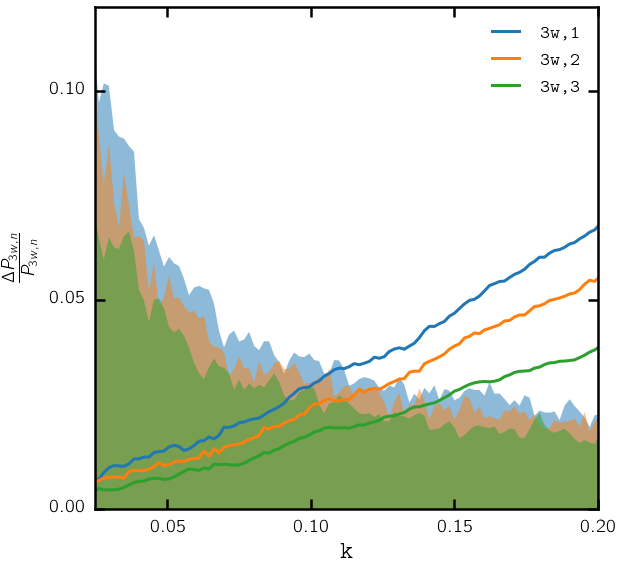

In [14]:
fig = plt.figure(figsize=(9,9))
sub = fig.add_subplot(111)

for i_en, en in enumerate([1,2,3]): 
    Pwed = [avg_Pk_wedge_true['k'], avg_Pk_wedge_true[str(en)+',3']]
    Pwed_NN = [avg_Pk_wedge_NN['k'], avg_Pk_wedge_NN[str(en)+',3']]
    
    sub.fill_between(Pwed[0], np.zeros(len(Pwed[1])), sigma_Pk_wedge_true[str(en)+',3']/Pwed[1], color=pretty_colors[2*i_en+1], lw=0, alpha=0.5)
    
    sub.plot(Pwed[0], np.abs(Pwed_NN[1] - Pwed[1])/Pwed[1], c=pretty_colors[2*i_en+1], lw=3, label=r'3w,'+str(en))
    #sub.plot(Pwed_NN[0], Pwed_NN[0]*Pwed_NN[1], c=pretty_colors[i_en+1], label=r'$k\,P_{3w,'+str(en)+'}^{NN}(k)$')

sub.set_xlabel('k', fontsize=25)
sub.set_ylabel(r'$\frac{\Delta P_{3w, n}}{P_{3w,n}}$', fontsize=25)
sub.set_xlim([0.025, 0.2])
sub.set_ylim([0., 0.12])
sub.set_xticks([0.05, 0.10, 0.15, 0.2])
sub.set_yticks([0., 0.05, 0.1])
sub.legend(loc='upper right', scatterpoints=1)

Curiously, the wedges with lower $\mu$ are affect more by fiber collisions...

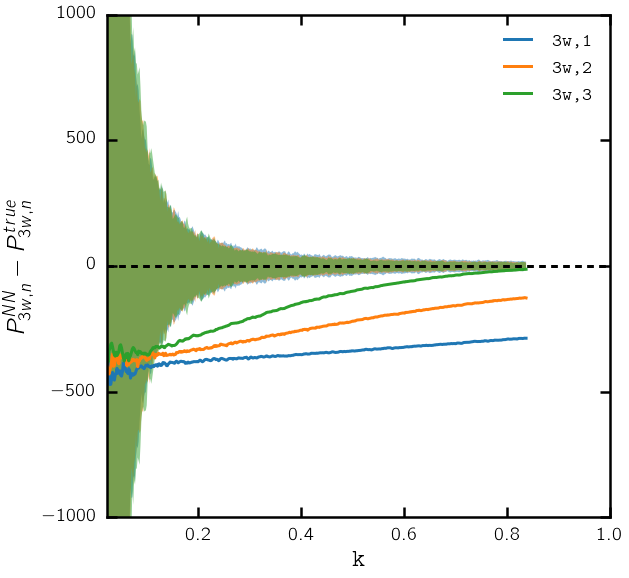

In [15]:
fig = plt.figure(figsize=(9,9))
sub = fig.add_subplot(111)

for i_en, en in enumerate([1,2,3]): 
    Pwed = [avg_Pk_wedge_true['k'], avg_Pk_wedge_true[str(en)+',3']]
    Pwed_NN = [avg_Pk_wedge_NN['k'], avg_Pk_wedge_NN[str(en)+',3']]
    
    sub.fill_between(Pwed[0], np.zeros(len(Pwed[1])), sigma_Pk_wedge_true[str(en)+',3'], color=pretty_colors[2*i_en+1], lw=0, alpha=0.5)
    sub.fill_between(Pwed[0], -1.*sigma_Pk_wedge_true[str(en)+',3'], np.zeros(len(Pwed[1])), color=pretty_colors[2*i_en+1], lw=0, alpha=0.5)
    
    sub.plot([0.001, 1.], [0., 0.], c='k', ls='--', lw=3)
    sub.plot(Pwed[0], Pwed_NN[1] - Pwed[1], c=pretty_colors[2*i_en+1], lw=3, label=r'3w,'+str(en))
    #sub.plot(Pwed_NN[0], Pwed_NN[0]*Pwed_NN[1], c=pretty_colors[i_en+1], label=r'$k\,P_{3w,'+str(en)+'}^{NN}(k)$')

sub.set_xlabel('k', fontsize=25)
sub.set_ylabel(r'$P^{NN}_{3w, n} - P^{true}_{3w,n}$', fontsize=25)
sub.set_xlim([0.025, 1.])
sub.set_ylim([-1000., 1000.])
#sub.set_xticks([0.05, 0.10, 0.15, 0.2])
#sub.set_yticks([0., 0.05, 0.1])
sub.legend(loc='upper right', scatterpoints=1)